In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import create_y_data
from bo_functions import bo_iter
from bo_functions import test_train_split
from bo_functions import bo_iter_w_runs
from datetime import datetime

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = None ##For Testing

#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 3
train_iter = 300
noise_std = 0.1
runs = 1
explore_bias = torch.tensor([0.75])
shuffle_seed = 6
set_lengthscale = np.array([None])
# t= 20
emulator = True
sparse_grid = True
verbose = True
save_fig=False

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays

Date and Time:  21-Jul-2022 (14:53:31)


Runs: 1
BO Iters: 3
------------------------------
Lengthscale Set To: [None]
Explore Bias: 0.75
Run Number:  1


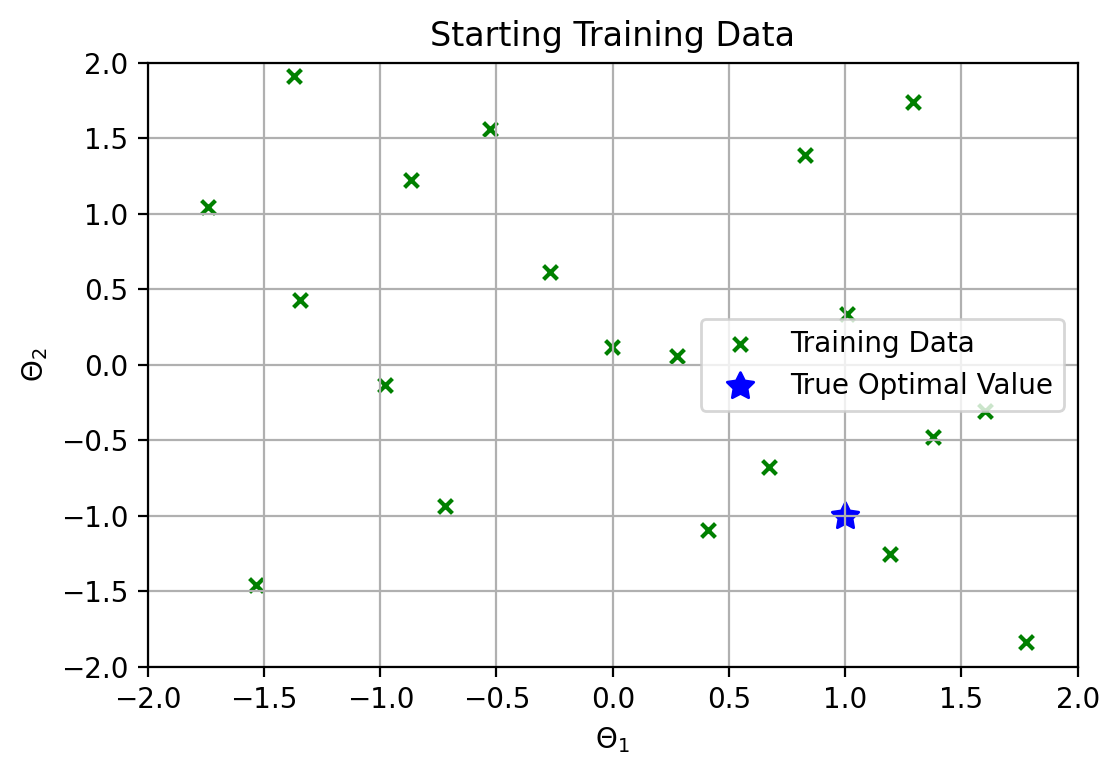

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Theta =  [ 0.94736842 -0.94736842]
True
GP Mean [-8.13506074 -6.20566937 -2.12571965  1.94320189  4.09535454]
GP Stdev [2.52731905 2.46460076 2.50804568 2.4902496  2.59806655]
SSE 0.16030816129821882
5
5


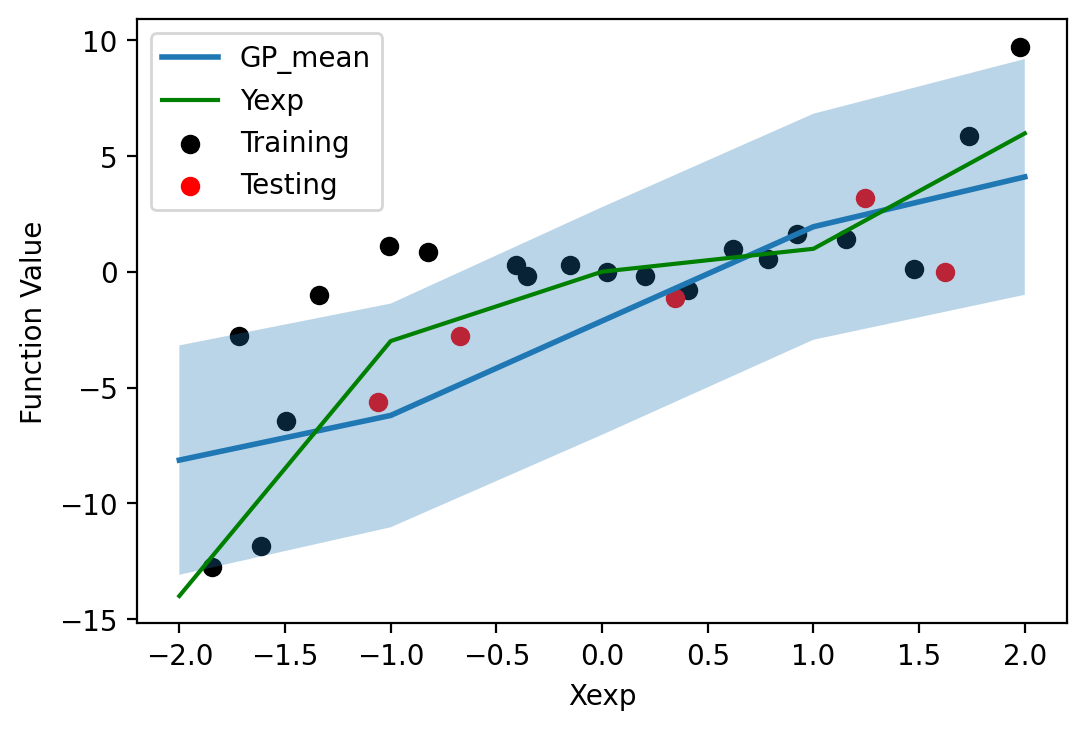

BO Iteration =  1
Exploration Bias =  tensor(0.7500)
Scipy Theta Best =  [-1.78947368 -2.        ]
Argmax Theta Best =  [-1.78947368 -2.        ]
Scipy Theta Opt =  [ 1.38979445 -0.86053279]
Argmin Theta_Opt_GP =  [ 1.36842105 -0.94736842] 



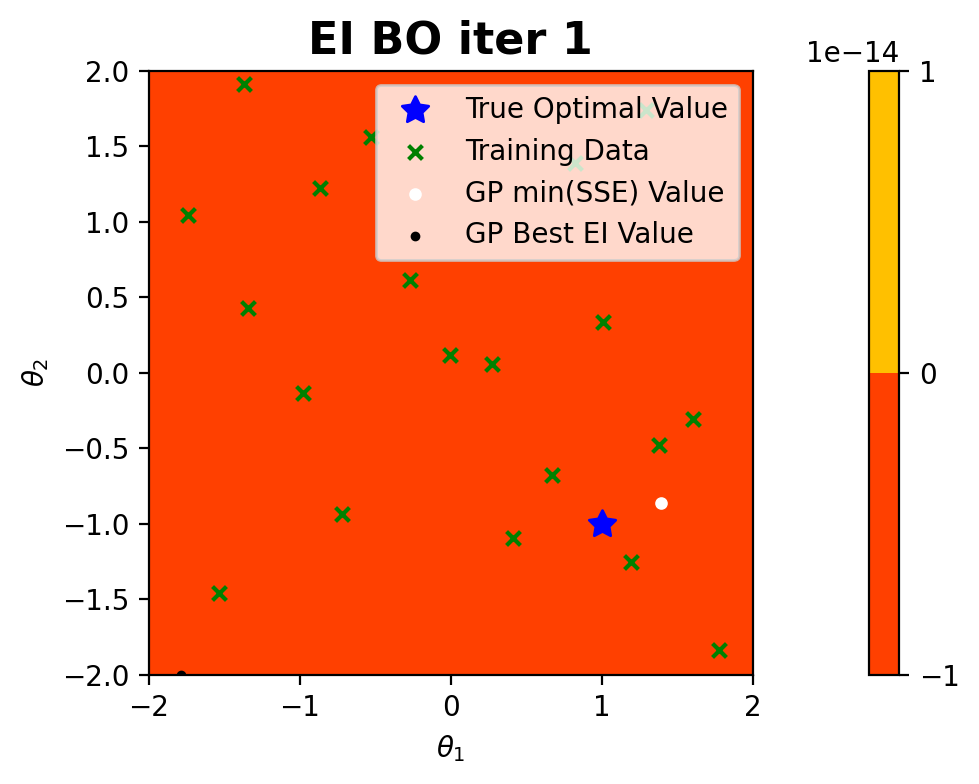

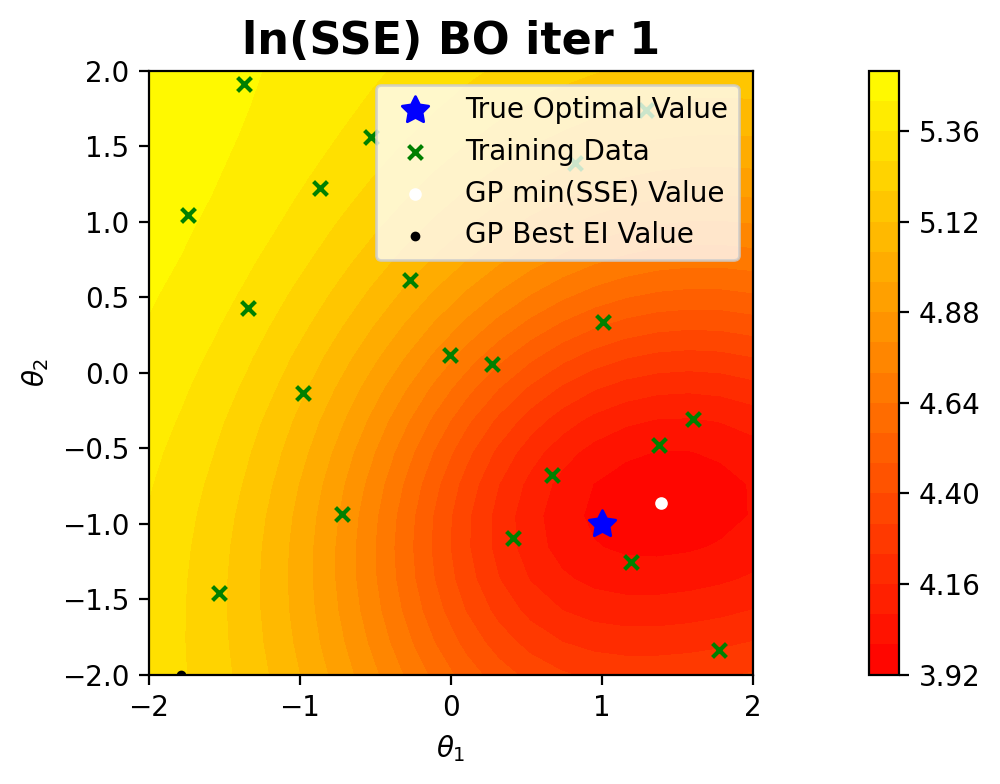

Best Error is: 0.12832025371240505


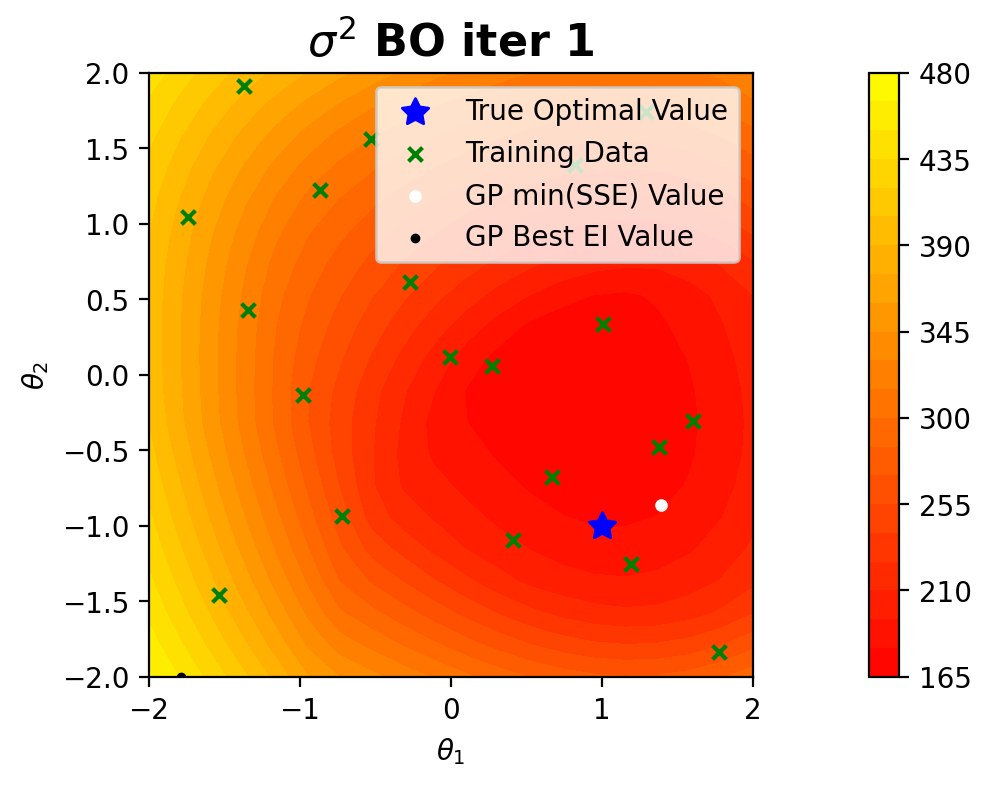

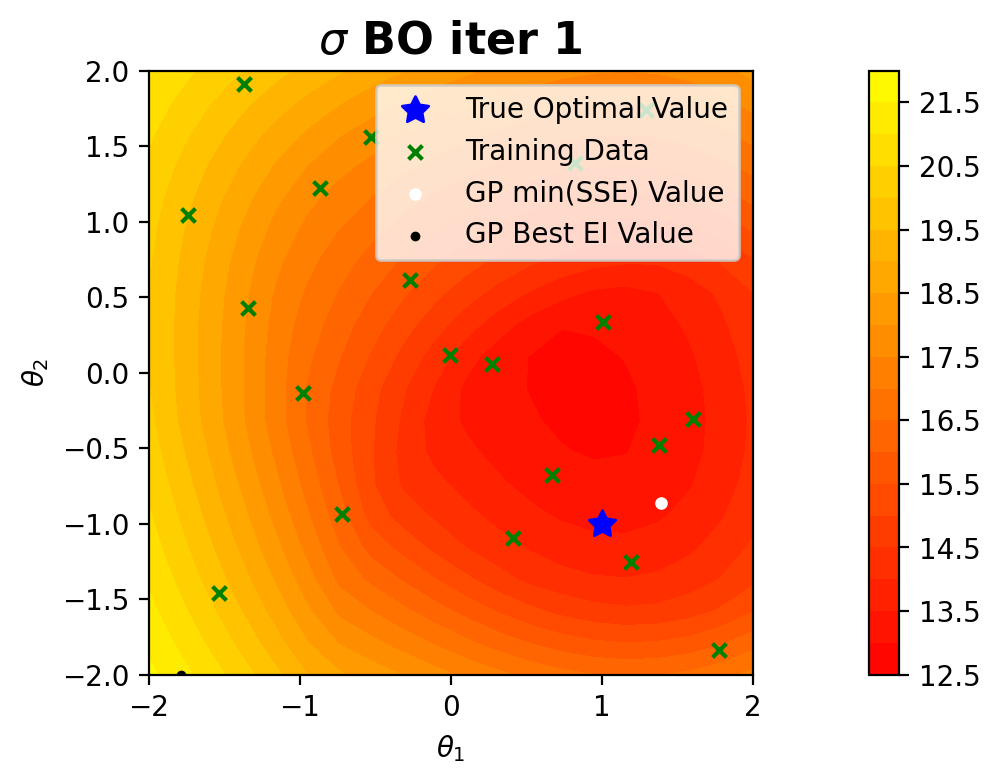

Magnitude of ln(SSE) given Theta_Opt =  [ 1.38979445 -0.86053279] is 8.1528e-01
Theta =  [ 0.94736842 -0.94736842]
True
GP Mean [-8.30919242 -6.0365645  -1.98039729  1.66992712  3.24980259]
GP Stdev [2.7685178  2.71420161 2.75152267 2.7344056  2.83199393]
SSE 1.901409865645637
5
5


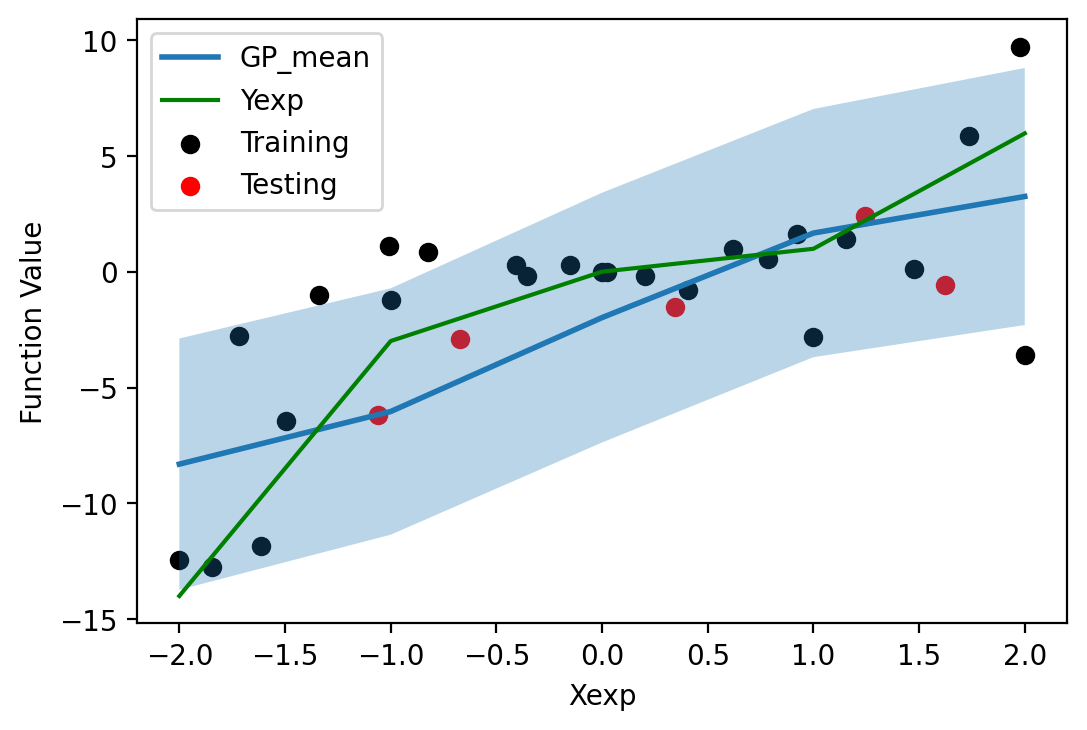

BO Iteration =  2
Exploration Bias =  tensor(0.7500)
Scipy Theta Best =  [-1.78947368 -2.        ]
Argmax Theta Best =  [-1.78947368 -2.        ]
Scipy Theta Opt =  [ 1.1257221  -0.84922359]
Argmin Theta_Opt_GP =  [ 1.15789474 -0.94736842] 



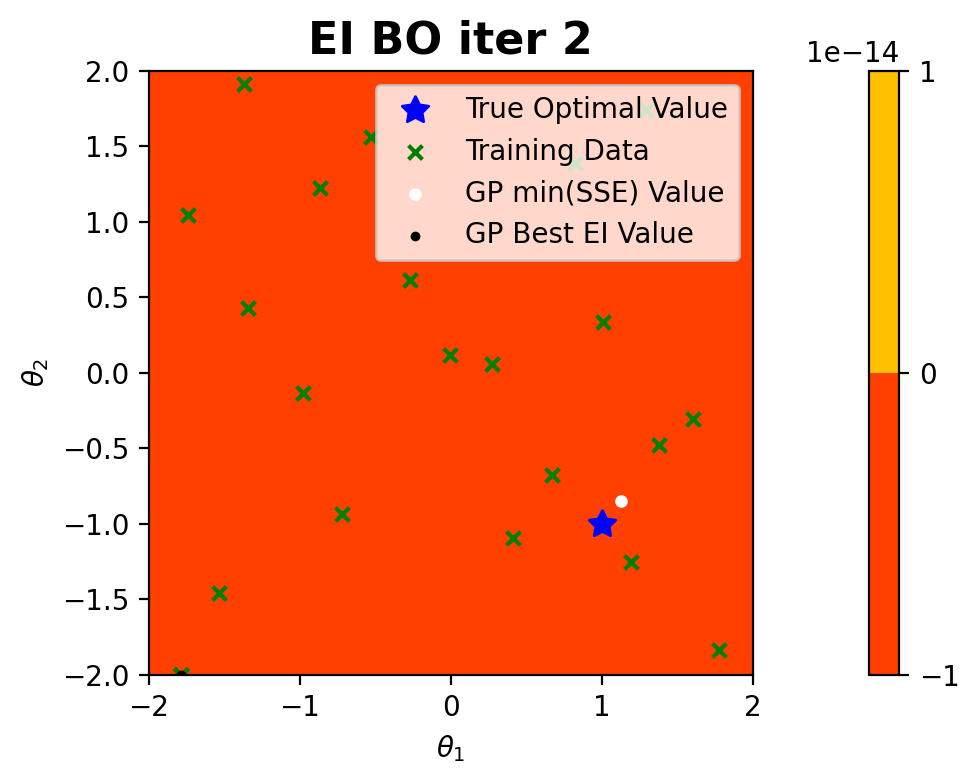

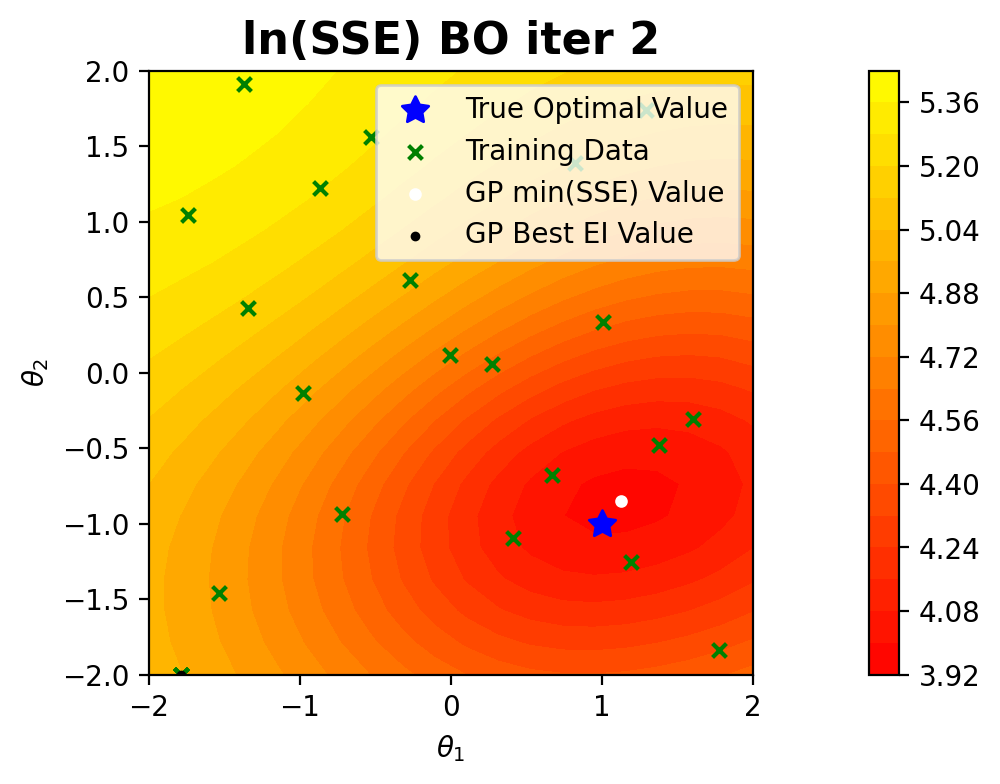

Best Error is: 0.12832025371240505


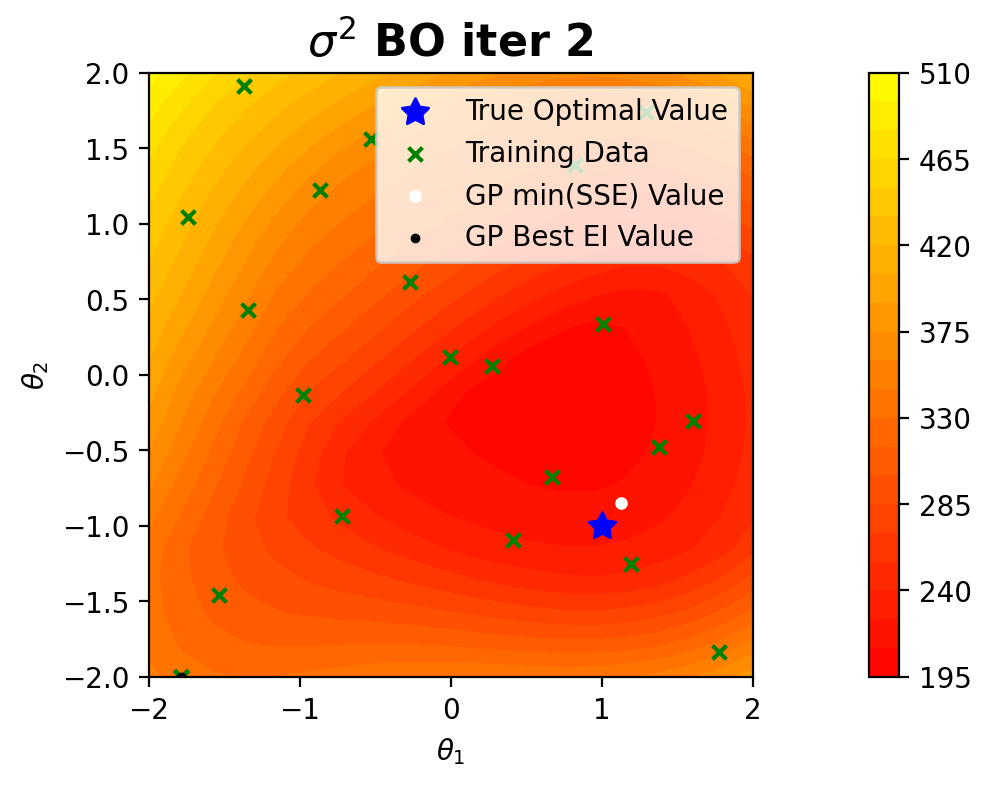

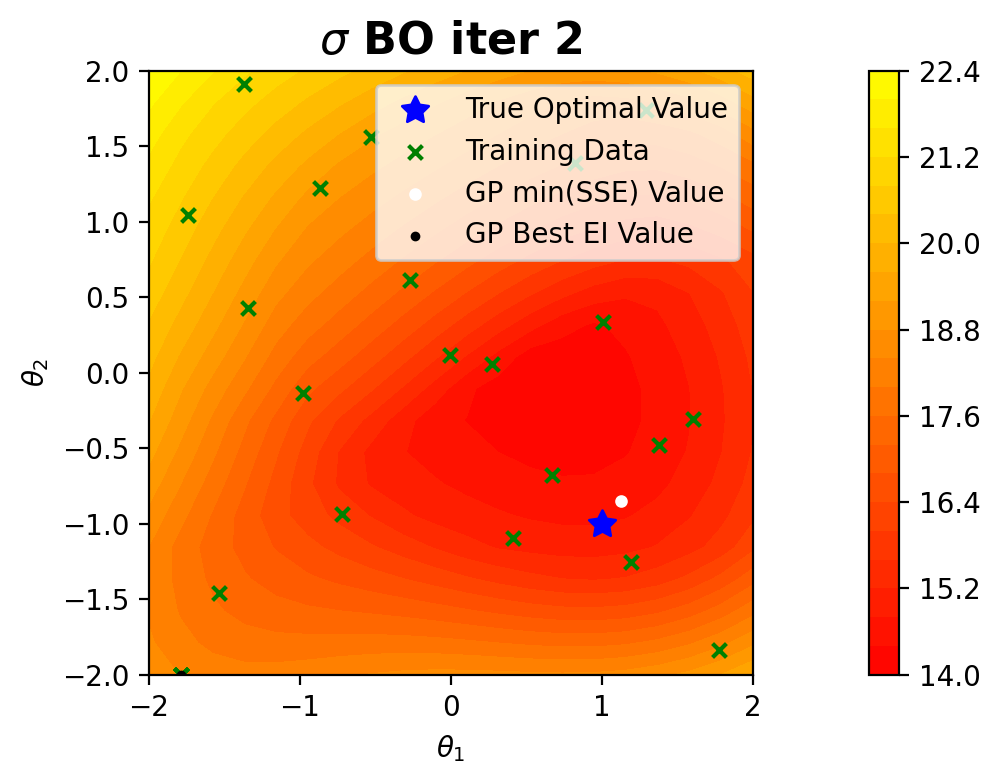

Magnitude of ln(SSE) given Theta_Opt =  [ 1.1257221  -0.84922359] is -1.9113e-02
Theta =  [ 0.94736842 -0.94736842]
True
GP Mean [-8.58474423 -6.31646557 -2.00147364  1.81305562  3.46667927]
GP Stdev [2.71917859 2.69013543 2.73641823 2.69752343 2.81496163]
SSE 2.545429504030497
5
5


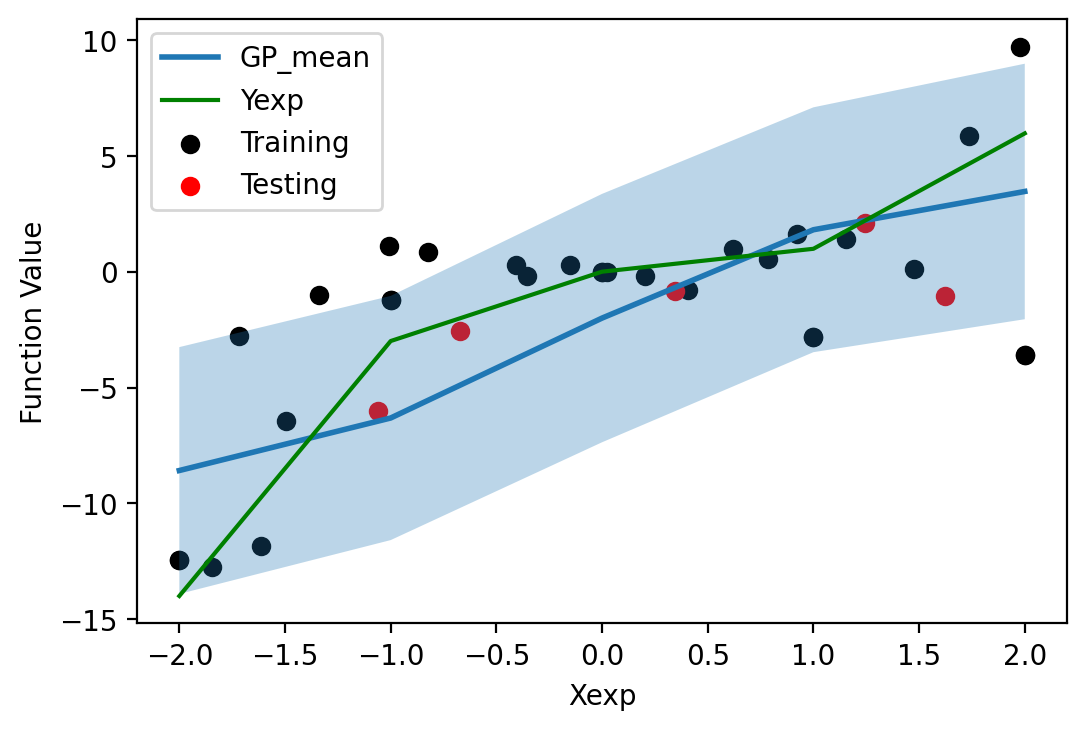

BO Iteration =  3
Exploration Bias =  tensor(0.7500)
Scipy Theta Best =  [-1.78947368 -2.        ]
Argmax Theta Best =  [-1.78947368 -2.        ]
Scipy Theta Opt =  [ 0.98279517 -0.8815133 ]
Argmin Theta_Opt_GP =  [ 0.94736842 -0.94736842] 



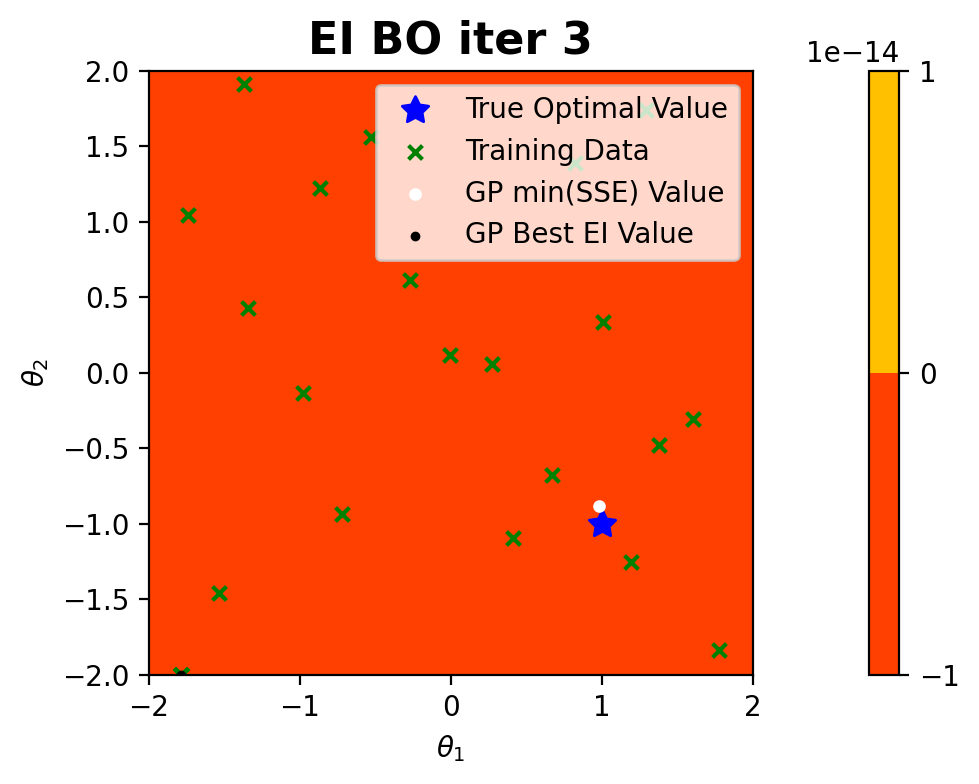

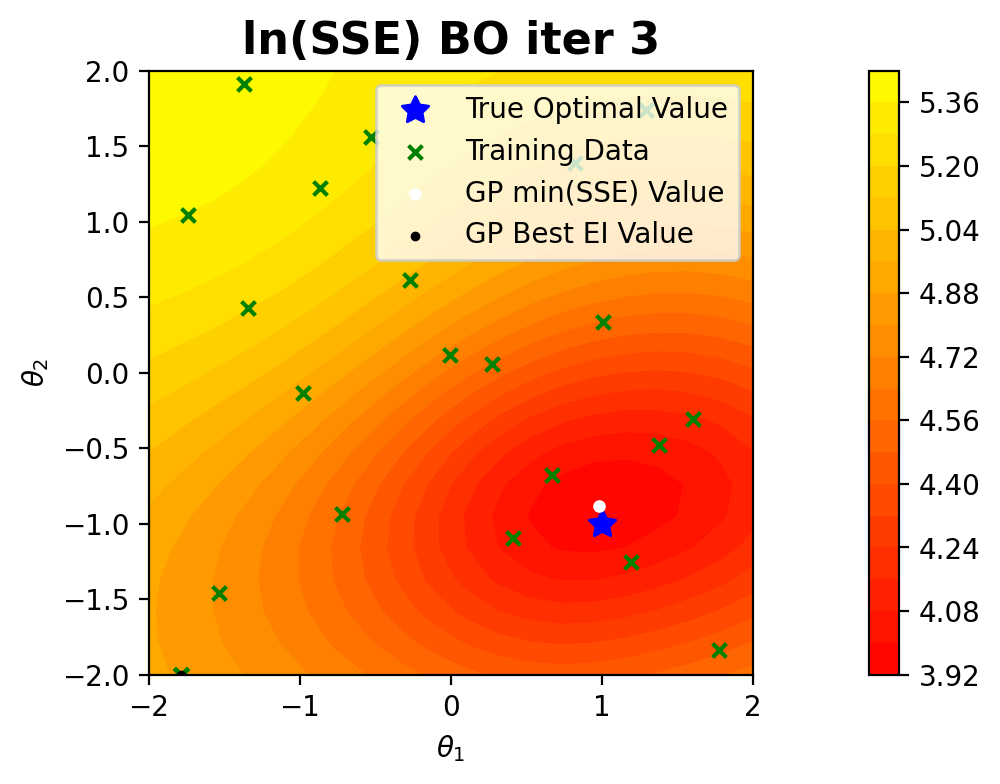

Best Error is: 0.12832025371240505


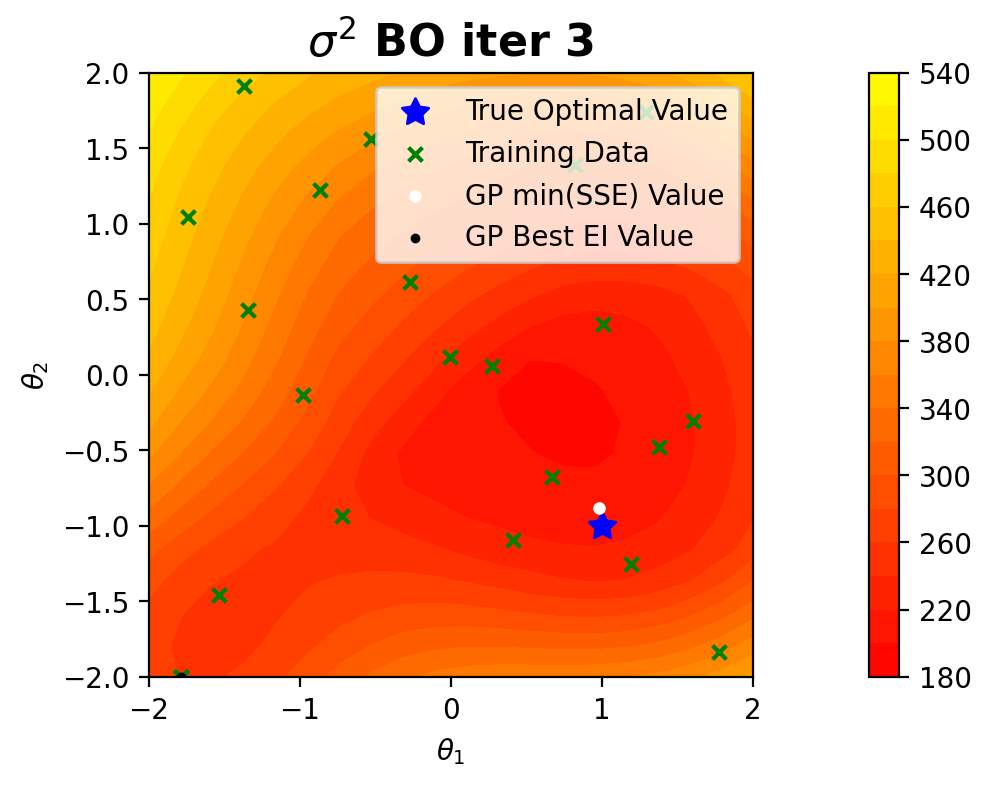

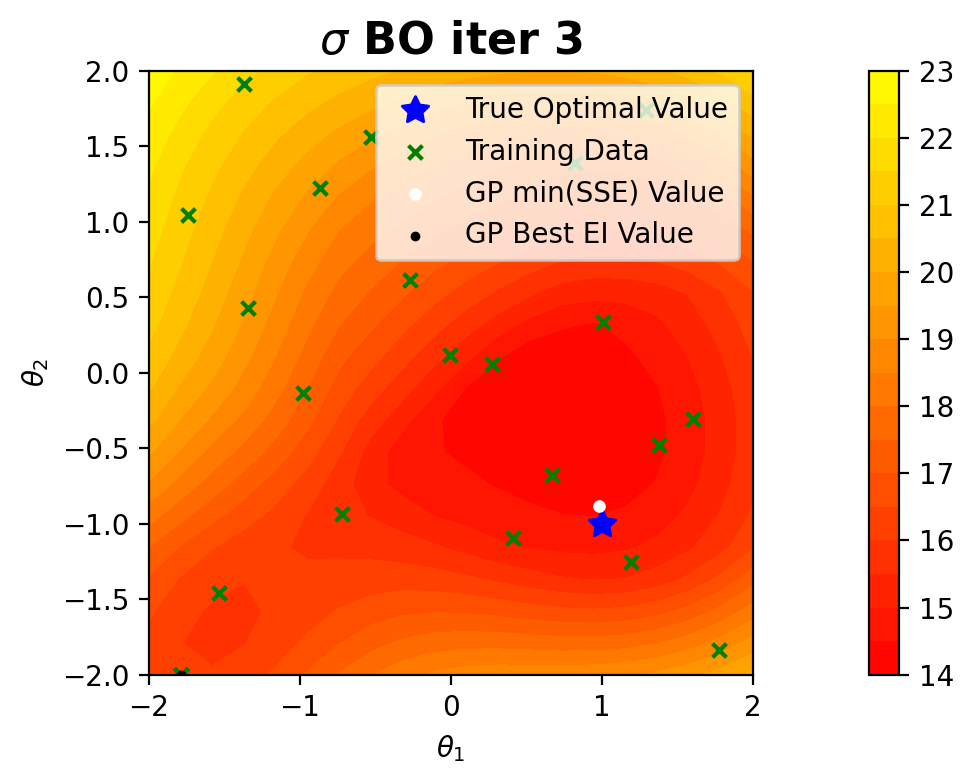

Magnitude of ln(SSE) given Theta_Opt =  [ 0.98279517 -0.8815133 ] is -6.8136e-01


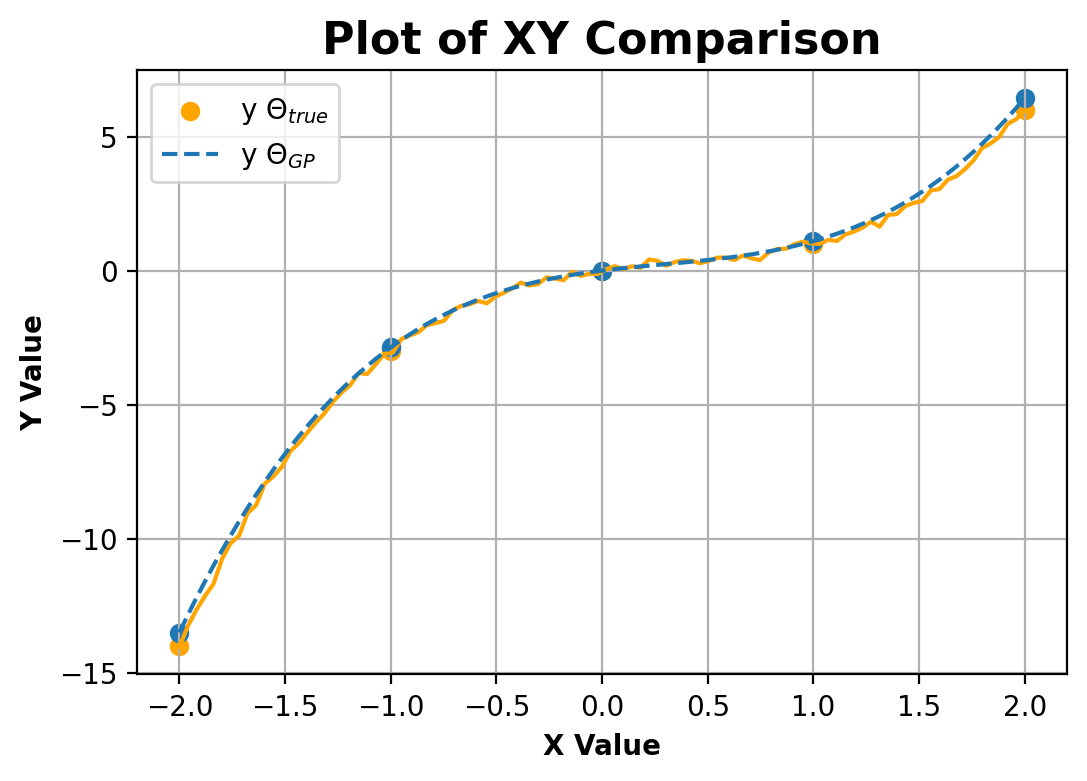

The GP predicts the lowest SSE of 5.059e-01 occurs at θ = [ 0.98279517 -0.8815133 ] during run 1 at BO iteration 3
At this point, the highest EI occurs at θ = [-1.78947368 -2.        ]
CPU times: user 18.9 s, sys: 243 ms, total: 19.2 s
Wall time: 19.3 s


In [3]:
%%time
obj = "obj"

all_data_doc = "Input_CSVs/Train_Data/all_3_data/t=25.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=",")) 

t = len(all_data)

print("Runs:", runs)
print("BO Iters:",BO_iters)
print("------------------------------")
for i in range(len(set_lengthscale)):
    for j in range(len(explore_bias)):
        print("Lengthscale Set To:", set_lengthscale)
        print("Explore Bias:", str(np.round(float(explore_bias[j]),3)))
        results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[j], Xexp, Yexp,
                                     noise_std, obj, runs, sparse_grid, emulator, set_lengthscale[i], verbose, 
                                     save_fig, shuffle_seed, DateTime)
        print("The GP predicts the lowest SSE of", "{:.3e}".format(np.exp(results[3])), "occurs at \u03B8 =", results[2][0], 
                  "during run", results[1], "at BO iteration", results[0])
        print("At this point, the highest EI occurs at \u03B8 =", results[4][0])